In [836]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import scipy.integrate as integrate

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from IPython.display import display, Markdown, Latex

Data una distribuzione di probabilità $f(x)$ di posteriori Bayesiani della variabile aleatoria discreta $x$, l'intervallo di credibilità $\mathbf{HDI}_p$ (High Density Interval) corrispondente alla regione a maggior densità di probabilità, scelto il valore di $p\in(0,1)$ è

$$
\mathbf{HDI}_p = [a, b] \in x, a < b \; : \; f(a) \simeq f(b), \; \int_{a}^{b} f(x) \simeq p
$$

Esistono diversi metodi per il calcolo di $\mathbf{HDI}_p$ [ref] ed i vantaggi/svantaggi di ciascuno dipendono dal tipo di studio effettuato.

In generale, laddove siano noti solo i valori $\{x,f(x)\}$ ma non la funzione di distribuzione, è possibile calcolare l'intervallo integrando con regola di Simpson a partire dal valore massimo di $f(x)$ fino a che $\int_{a}^{b} [x,f(x)]<p$ ottenenendo così il minor intervallo $[a,b]$ tale per cui l'area sottesa dalla curva sia "il più possibile" vicina a $p$.

Un metodo equivalente [ref] consiste nel calcolare la probabilità cumulativa

$$ F = \sum f(x) $$

ottenere la matrice quadrata antisimmetrica

$$ \Delta\mathbf{F} = F - F^{T} = 
\begin{Bmatrix}
F_{0} - F_{0} & F_{1} - F_{0} & \cdots & F_{|x|-1} - F_{0} & F_{|x|} - F_{0} \\
F_{0} - F_{1} & F_{1} - F_{1} & \cdots & F_{|x|-1} - F_{1} & F_{|x|} - F_{1} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
F_{0} - F_{|x|-1} & F_{1} - F_{|x|-1} & \cdots & F_{|x|-1} - F_{|x|-1} & F_{|x|} - F_{|x|-1} \\
F_{0} - F_{|x|} & F_{1} - F_{|x|} & \cdots & F_{|x|-1} - F_{|x|} & F_{|x|} - F_{|x|} \\
\end{Bmatrix}_{|x| \times |x|}
$$

e gli elementi $\Delta\mathbf{F}_{n,m}>p$ di riga $n$ e colonna $m$.

Gli indici dell'elemento tale per cui è minore la differenza tra $m$ (limite superiore) ed $n$ (limite inferiore), i  rappresentano l'intervallo di credibilità, ovvero

$$ \mathbf{HDI}_p = [n, m] \in x, n < m \; : \; \min(m - n), \; \forall n, m \in \Delta\mathbf{F}_{n,m}>p $$

Sia data ad esempio una distribuzione di probabilità con asimmetria positiva ($SK=3$, $\mu=7$, $\sigma=6$) della variabile aleatoria discreta $x \in [0,30]$ (figura).
Fissando $p=.9$ l'intervallo di credibilità Bayesiano è dato dalla curva sottesa tra $x=5$ e $x=18$.

Utilizzando il metodo della matrice antisimmetrica, si calcola la probabilità cumulativa $F$ e la matrice $\Delta\mathbf{F}$ (figura). Gli elementi $\Delta\mathbf{F}_{n,m}>.9$ sono delimitati dall'area blu in figura (figura). L'elemento che soddisfa la [equazione] è $\Delta\mathbf{F}_{5,18}=0.91$ (quadrato giallo in figura).

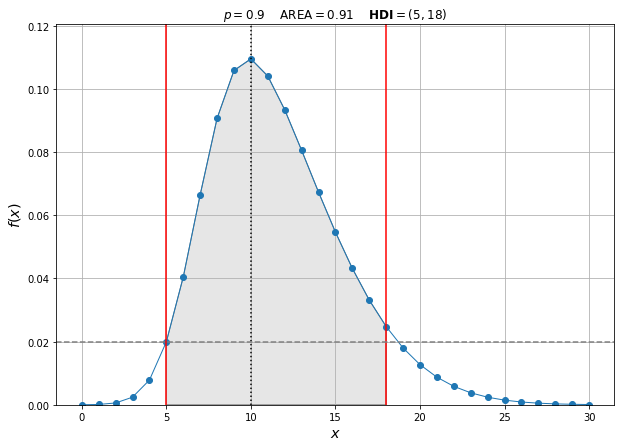

In [829]:
num = 30; skew = 3; mean = 7; std = 6; p = .9
x = np.linspace(0, num, num+1)

PAIRS = []
sol = None

sy = sps.skewnorm.pdf(x, skew, mean, std)
y = sps.skewnorm.cdf(x, skew, mean, std)

for i in np.linspace(sy[sy.argmax()], 0, 100):
    points = (sy >= i).nonzero()[0]
    PAIRS.append(
        [min(points), max(points)]
    )
    #ar2 = integrate.quad(lambda x: sps.skewnorm.pdf(x, skew, mean, std), min(points), max(points))
    ar = integrate.simps(sy[min(points):max(points)+1])
    if ar > p and not sol:
        sol = [i, min(points), max(points), ar]

fig, ax = plt.subplots(figsize=(10,7))
plt.plot(sy, lw=1, marker="o")
verts = [
    (sol[1], 0),
    *zip(x[sol[1]:sol[2]+1], sps.skewnorm.pdf(x[sol[1]:sol[2]+1], 3, 7, s*2)), 
    (sol[2], 0)
]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly)
plt.axvline(7+3, ls=":", c="k")
plt.axvline(sol[1], c="r")
plt.axvline(sol[2], c="r")
plt.axhline(sol[0], ls="--", c="grey")
ax.set_ylim(0, max(sy)*1.1)
ax.set_title(f"$p={p}$    AREA$={sol[3]:.2f}$    $\mathbf{{HDI}}=({sol[1]},{sol[2]})$")
ax.set_xlabel("$x$", fontsize="x-large")
ax.set_ylabel("$f(x)$", fontsize="x-large")
plt.grid();

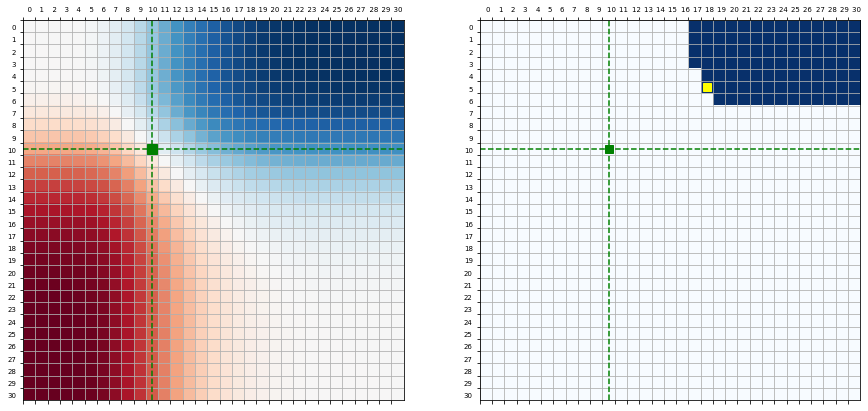

In [835]:
matrix = y - y[:, None]

fig, ax = plt.subplots(1, 2, figsize=(15,7))

ax[0].matshow(matrix, cmap="RdBu")
ax[0].plot(m, m, marker="s", c="g", markersize=10)
ax[0].axvline(m, ls="--", c="g")
ax[0].axhline(m, ls="--", c="g")
ax[0].set_xticks(x-.5)
ax[0].set_xticklabels([f"      {i}" for i in range(num+1)], fontsize="x-small")
ax[0].set_yticks(x-.5)
ax[0].set_yticklabels([f"\n\n{i}" for i in range(num+1)], fontsize="x-small")
ax[0].set_xlim(-0.5, num+.5)
ax[0].set_ylim(num+.5, -0.5)
ax[0].grid()

ax[1].matshow(pd.DataFrame(matrix > p), cmap="Blues")
ax[1].plot(m, m, marker="s", c="g", markersize=8)
ax[1].axvline(m, ls="--", c="g")
ax[1].axhline(m, ls="--", c="g")

ax[1].set_xticks(x-.5)
ax[1].set_xticklabels([f"        {i}" for i in range(num+1)], fontsize="x-small")
ax[1].set_yticks(x-.5)
ax[1].set_yticklabels([f"\n\n{i}" for i in range(num+1)], fontsize="x-small")
ax[1].plot(18, 5, marker="s", c="yellow", markersize=8)
ax[1].set_xlim(-0.5, num+.5)
ax[1].set_ylim(num+.5, -0.5)
ax[1].grid();

In [856]:
pd.DataFrame(
    matrix[:8,16:].round(2),
    columns=[16+i for i in range(31-16)]
);

In [866]:
display(
    Latex(
        fr"""
\begin{{table}}
  \begin{{center}}
    \caption{{Estratto di matrice $\Delta\mathbf{{F}}$}}
    \label{{tab:deltaf}}
    \resizebox{{\textwidth}}{{!}} {{
    \begin{{tabular}}{{{"c|" * 16}}}
        & {" & ".join([f"{i+16}" for i in range(15)])} \\
        \toprule
        0 & {" & ".join([f"{matrix[0,i+16]:.2f}" for i in range(15)])} \\
        \midrule
        1 & {" & ".join([f"{matrix[1,i+16]:.2f}" for i in range(15)])} \\
        \midrule
        2 & {" & ".join([f"{matrix[2,i+16]:.2f}" for i in range(15)])} \\
        \midrule
        3 & {" & ".join([f"{matrix[3,i+16]:.2f}" for i in range(15)])} \\
        \midrule
        4 & {" & ".join([f"{matrix[4,i+16]:.2f}" for i in range(15)])} \\
        \midrule
        5 & {" & ".join([f"{matrix[5,i+16]:.2f}" for i in range(15)])} \\
        \midrule
        6 & {" & ".join([f"{matrix[6,i+16]:.2f}" for i in range(15)])} \\
        \midrule
        7 & {" & ".join([f"{matrix[7,i+16]:.2f}" for i in range(15)])} \\
        \midrule
        \bottomrule
    \end{{tabular}} }}
  \end{{center}}
\end{{table}}
        """
    )
)

<IPython.core.display.Latex object>

In [865]:
matrix_p = matrix > p
display(
    Latex(
        fr"""
\begin{{table}}
  \begin{{center}}
    \caption{{Estratto di matrice $\Delta\mathbf{{F}}>p$}}
    \label{{tab:deltafp}}
    \resizebox{{\textwidth}}{{!}} {{
    \begin{{tabular}}{{{"c|" * 16}}}
        & {" & ".join([f"{i+16}" for i in range(15)])} \\
        \toprule
        0 & {" & ".join([f"{matrix_p[0,i+16]}" for i in range(15)])} \\
        \midrule
        1 & {" & ".join([f"{matrix_p[1,i+16]}" for i in range(15)])} \\
        \midrule
        2 & {" & ".join([f"{matrix_p[2,i+16]}" for i in range(15)])} \\
        \midrule
        3 & {" & ".join([f"{matrix_p[3,i+16]}" for i in range(15)])} \\
        \midrule
        4 & {" & ".join([f"{matrix_p[4,i+16]}" for i in range(15)])} \\
        \midrule
        5 & {" & ".join([f"{matrix_p[5,i+16]}" for i in range(15)])} \\
        \midrule
        6 & {" & ".join([f"{matrix_p[6,i+16]}" for i in range(15)])} \\
        \midrule
        7 & {" & ".join([f"{matrix_p[7,i+16]}" for i in range(15)])} \\
        \midrule
        \bottomrule
    \end{{tabular}} }}
  \end{{center}}
\end{{table}}
        """
    )
)

<IPython.core.display.Latex object>

In [862]:
pd.DataFrame(
    matrix[:8,16:] > p,
    columns=[16+i for i in range(31-16)]
);

In [863]:
los, his = (matrix > p).nonzero()

In [864]:
best = (his - los).argmin()